# Single-Qubit Tomography

## Theory

For single-qubit states the general expression for their density matrices can be written uniquely as:
$$\hat{\rho} = \frac{1}{2} \sum_{i=0}^{3} S_i \hat{\sigma}_i. \tag{1}$$
Where $\hat{\sigma}_i$ are the Pauli matrices (Including the 2x2 identity matrix as $\hat{\sigma}_0$) and $S_i$ are the values given by:
$$S_i = Tr\{\hat{\sigma}_i\hat{\rho}\}. \tag{2}$$
It is also useful to note that, 
1. For all pure states: $\sum_{i=1}^{3} S_i^2 = 1$.
2. For mixed states: $\sum_{i=1}^{3} S_i^2 < 1$.
3. For the completely mixed state:  $\sum_{i=1}^{3} S_i^2 = 0$.
4. Due to the normalization condition for quantum states it is always the case that: $S_0^2 = 1$.

The above contents are from page 117 of the book Quantum State Estimation. Proofs of (1) and (2) to be added in the future.

For a quantum state represented by density matrix $\hat{\rho}$ the expectation value for an observable $\Omega$ is given by:
$$\langle \hat{\Omega} \rangle = \sum_{i} p_i \bra{i} \Omega \ket{i} = Tr \{ \hat{\Omega} \hat{\rho} \}. \tag{3}$$
Thus, using (1) and (3), we can represent the density matrix for a single-qubit state as:
$$\hat{\rho} = \frac{1}{2} \sum_{i=0}^{3} \langle \hat{\sigma}_i \rangle \hat{\sigma}_i. \tag{4}$$

Note that in the above case we only considered orthogonal measurement bases of the pauli matrices. We are not constrained to orthogonal measurment bases an can instead (page 118 from quantum state extimation).

## Example 1 (With orthogonal measurment basis)

Prepare a single-qubit state using the prepare_state gate available in qiskit.

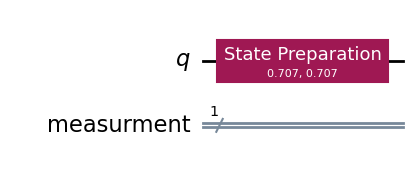

In [18]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import *

# Instantiate quantum and classical registers each of 1 bit.
qr = QuantumRegister (1, 'q')
cr = ClassicalRegister(1, 'measurment')

# Create a quantum circuit and add the prepare_state function acting on qubit 0.
qc = QuantumCircuit(qr, cr)
qc.prepare_state(state = [1/np.sqrt(2), 1/np.sqrt(2)], qubits = 0)

# Draw the ciruit in mpl (matplotlib).
qc.draw("mpl")

Prepare a single-qubit state using the prepare_state gate available in qiskit.

Getting the expectation values. Using the StatevectorSampler available in qiskit I can simulate measurment on the qubits in the circuit. I know I will need to obtain 3 expectation values ($\langle \hat{\sigma_0} \rangle$ is always 1) 

In [19]:
xMeasure = QuantumCircuit(1,1)
xMeasure.append(HGate(), [0])
xMeasure.measure(0,0)

yMeasure = QuantumCircuit(1,1)
yMeasure.append(SdgGate(), [0])
yMeasure.append(HGate(), [0])
yMeasure.measure(0,0)

zMeasure = QuantumCircuit(1,1)
zMeasure.measure(0,0)

basis = [xMeasure, yMeasure, zMeasure]

Comment below

In [20]:
from qiskit.primitives import StatevectorSampler

exp = [] # Array to store expectation values.
shots = 100 # Number of times to run the circuit.

sampler = StatevectorSampler(default_shots = shots) # Record variable number of samples of the circuit (more samples improve accuracy).

for i in basis:
    result = sampler.run([qc.compose(i)]).result()[0] # Run the sampler on the quantum circuit and store the result.

    data = result.data # Get the data from the result of running the circuit.

    counts = data.measurment.get_counts()

    if '0' not in counts.keys():
        counts['0'] = 0
    if '1' not in counts.keys():
        counts['1'] = 0

    exp.append((counts['0'] - counts['1'])/shots)

    print(f"The counts are: {counts}")
    
print(exp)




The counts are: {'0': 100, '1': 0}
The counts are: {'0': 47, '1': 53}
The counts are: {'0': 44, '1': 56}
[1.0, -0.06, -0.12]


Reconstruct the state.

In [21]:
x, y ,z = exp

rho =   (1/2)*np.array([[(1+z),(x-y*1j)],
                        [(x+y*1j),(1-z)]])

print(rho)

[[0.44+0.j   0.5 +0.03j]
 [0.5 -0.03j 0.56+0.j  ]]


## Example 2 (With non-orthogonal (non-parallel) measurment basis)

Prepare a single-qubit state using the prepare_state gate available in qiskit.

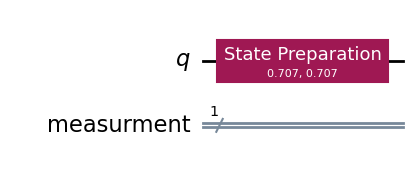

In [22]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import *

# Instantiate quantum and classical registers each of 1 bit.
qr = QuantumRegister (1, 'q')
cr = ClassicalRegister(1, 'measurment')

# Create a quantum circuit and add the prepare_state function acting on qubit 0.
qc = QuantumCircuit(qr, cr)
qc.prepare_state(state = [1/np.sqrt(2), 1/np.sqrt(2)], qubits = 0)

# Draw the ciruit in mpl (matplotlib).
qc.draw("mpl")

Define a non-orthogonal measurment basis. I picked these arbitrarily because they were easy to write.

Figure

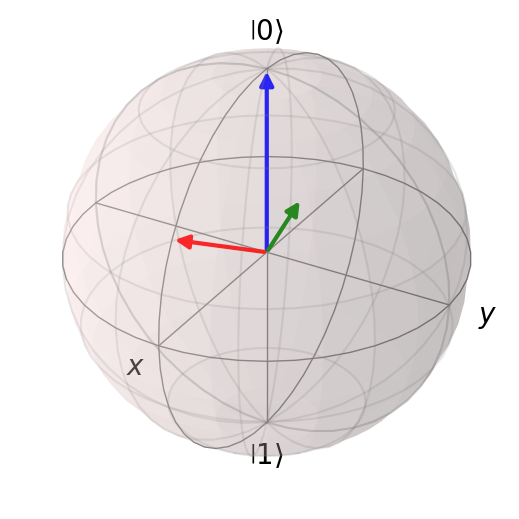

In [34]:
import numpy as np
import qutip

t1 = qutip.Qobj([np.sqrt(3)/2, 1/2])
t2 = qutip.Qobj([np.sqrt(3)/2,(1/4 + 1j/4)])
t3 = qutip.Qobj([1,0])
bloch =  qutip.Bloch()

bloch.add_states(state=t1, kind='vector')
bloch.add_states(state=t2, kind='vector')
bloch.add_states(state=t3, kind='vector')
bloch.vector_color = ['r', 'g', 'b']
bloch.show()

Code. The actual projective measurments along each of these axes corrosponds to rotating the state such that if it were to lay completely along one of the axes it would be rotated into the computational basis state $\ket{0}$. Then keeping this in mind we measure in the computational basis but the prior rotation allows us to effectivly measure in any of the other bases.

In [28]:
# An arbitrary single qubit unitary operator can be written in the form U = exp(ia)R_n(o).

def U (n, o, a): # n: Rotation axis; o: Angle of rotation; a: Phase.

    return np.exp(a*1j)*Rn(n, o)

def Rn (n, o): # n: Rotation axis; o: Angle of rotation.

    # Identity matrix
    I = np.array([[1,0],
                  [0,1]])
    
    # X-Pauli matrix
    X = np.array([[0,1],
                  [1,0]])
    
    # Y-Pauli matrix
    Y = np.array([[0,-1j],
                  [1j,0]])
    
    # Z-Pauli matrix
    Z = np.array([[1,0],
                  [0,-1]])

    return (np.cos(o/2)*I)-(np.sin(o/2)*(n[0]*X + n[1]*Y + n[2]*Z))*1j

# Define rotaton(s) to measure in the t1 basis.

# Graphically we can see that a rotation of 45 degrees about the y axis will work.

t1Measure = QuantumCircuit(1,1)
t1Measure.append (                          # Add a new gate to the circuit.
    UnitaryGate(U([0,1,0], np.pi/4, 0)),    # Gate to be added.
    [0]                                     # Qubit(s) on which it is acting.
)
t1Measure.measure(0,0)

# Define rotation(s) to measure in the t2 basis.

# Graphically we can see that a rotation of 45 degrees about the z axis 
# followed by a rotation of 45 gerees about the y axis will work.

t2Measure = QuantumCircuit(1,1)
t2Measure.append(
    UnitaryGate(U([0,0,1], np.pi/4, 0)), 
    [0]
)
t2Measure.append(
    UnitaryGate(U([0,1,0], np.pi/4, 0)), 
    [0]
)
t2Measure.measure(0,0)

# No rotation required for the t3 basis. It is just the computational basis.

t3Measure = QuantumCircuit(1,1)
t3Measure.measure(0,0)

basis = [t1Measure, t2Measure, t3Measure]

Comment below

In [30]:
from qiskit.primitives import StatevectorSampler

exp = [] # Array to store expectation values.
shots = 100 # Number of times to run the circuit.

sampler = StatevectorSampler(default_shots = shots) # Record variable number of samples of the circuit (more samples improve accuracy).

for i in basis:
    result = sampler.run([qc.compose(i)]).result()[0] # Run the sampler on the quantum circuit and store the result.

    data = result.data # Get the data from the result of running the circuit.

    counts = data.measurment.get_counts()

    if '0' not in counts.keys():
        counts['0'] = 0
    if '1' not in counts.keys():
        counts['1'] = 0

    exp.append((counts['0'] - counts['1'])/shots)

    print(f"The counts are: {counts}")
    
print(exp)




The counts are: {'0': 17, '1': 83}
The counts are: {'1': 78, '0': 22}
The counts are: {'1': 57, '0': 43}
[-0.66, -0.56, -0.14]


Using the method in the text we must transform our T parameters into the useful S parameters.

In [60]:
# The vectors defining the measurment basis.
v1 = [np.sqrt(3)/2, 1/2]
v1_perp = [1/2, -np.sqrt(3)/2]
v2 = [np.sqrt(3)/2, (1/4 + 1j/4)]
v2_perp = [(1/4 + 1j/4), -np.sqrt(3)/2]
v3 = [1, 0]
v3_perp = [0, 1]

# The Pauli matrices.
sigma0 = [[1,0],[0,1]]
sigma1 = [[0,1],[1,0]]
sigma2 = [[0,-1j],[1j,0]]
sigma3 = [[1,0],[0,-1]]
paulis = [sigma0, sigma1, sigma2, sigma3]

# The tau matrices.
tau0 = [[1,0],[0,1]]
tau1 = np.outer(v1, v1) - np.outer(v1_perp, v1_perp)
tau2 = np.outer(v2, v2) - np.outer(v2_perp, v2_perp)
tau3 = np.outer(v3, v3) - np.outer(v3_perp, v3_perp)
taus = [tau0, tau1, tau2, tau3]

# Generating the transformation matrix (equation 21). Should be invertible but....
T = [[]]
for x, i in enumerate(taus):
    for y, j in enumerate(paulis):
        T[x].append(np.trace(np.matmul(i,j)))

    T.append([])

T.pop()
T = np.array(T)
print(T)

T = np.linalg.inv(T)


[[2.        +0.j        0.        +0.j        0.        +0.j
  0.        +0.j       ]
 [0.        +0.j        1.73205081+0.j        0.        +0.j
  1.        +0.j       ]
 [0.        +0.j        0.8660254 +0.8660254j 0.        +0.j
  1.5       -0.25j     ]
 [0.        +0.j        0.        +0.j        0.        +0.j
  2.        +0.j       ]]


LinAlgError: Singular matrix